In [1]:
import pandas as pd 

In [2]:
df=pd.read_excel("Sample_data.xlsx")

In [7]:
df['DAY_NAME'].value_counts()

DAY_NAME
Wednesday    1475
Sunday       1472
Monday       1471
Thursday     1469
Saturday     1450
Friday       1448
Tuesday      1446
Name: count, dtype: int64

In [9]:
df['timestamp'] = pd.to_datetime(df['DOB']) + pd.to_timedelta(df['Hour'], unit='h')


In [11]:
df.set_index('timestamp', inplace=True)
df.sort_index(inplace=True)

In [13]:
df

DOB   DAY_NAME  Hour  Demand in Kgs
timestamp                                                      
2019-12-01 09:00:00  2019-12-01     Sunday     9        3.46070
2019-12-01 10:00:00  2019-12-01     Sunday    10        5.76400
2019-12-01 11:00:00  2019-12-01     Sunday    11        5.01463
2019-12-01 12:00:00  2019-12-01     Sunday    12        6.52433
2019-12-01 13:00:00  2019-12-01     Sunday    13        7.89140
...                         ...        ...   ...            ...
2021-12-01 19:00:00  2021-12-01  Wednesday    19       13.76500
2021-12-01 20:00:00  2021-12-01  Wednesday    20       18.72590
2021-12-01 21:00:00  2021-12-01  Wednesday    21        8.37200
2021-12-01 22:00:00  2021-12-01  Wednesday    22        6.94920
2021-12-01 23:00:00  2021-12-01  Wednesday    23        5.74450

[10231 rows x 4 columns]

In [15]:
df_cleaned = df[['Demand in Kgs']]


In [17]:
daily_demand = df_cleaned.resample('D').sum()


In [19]:
daily_demand

Demand in Kgs
timestamp                
2019-12-01       86.08262
2019-12-02       99.39785
2019-12-03       94.18793
2019-12-04       92.74619
2019-12-05      125.44786
...                   ...
2021-11-27      106.31790
2021-11-28      137.41240
2021-11-29      135.25930
2021-11-30      142.37290
2021-12-01      135.72870

[732 rows x 1 columns]

In [21]:
import plotly.express as px


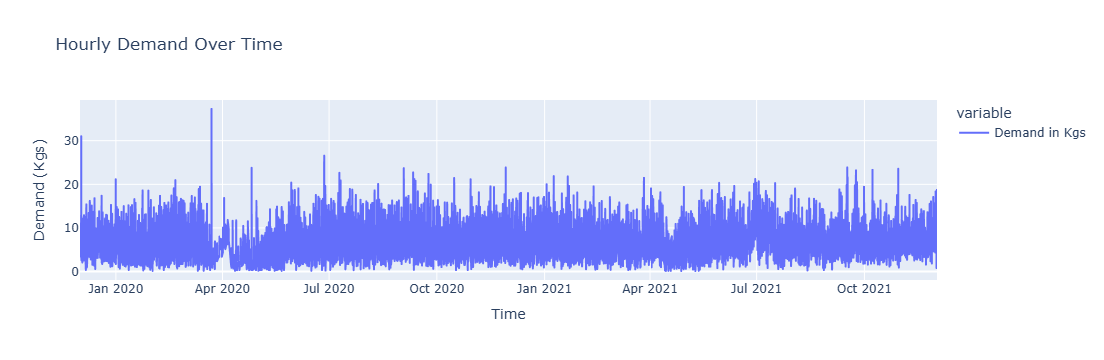

In [23]:
fig_hourly = px.line(df_cleaned, title='Hourly Demand Over Time', labels={'value': 'Demand in Kgs', 'timestamp': 'DateTime'})
fig_hourly.update_layout(xaxis_title='Time', yaxis_title='Demand (Kgs)')


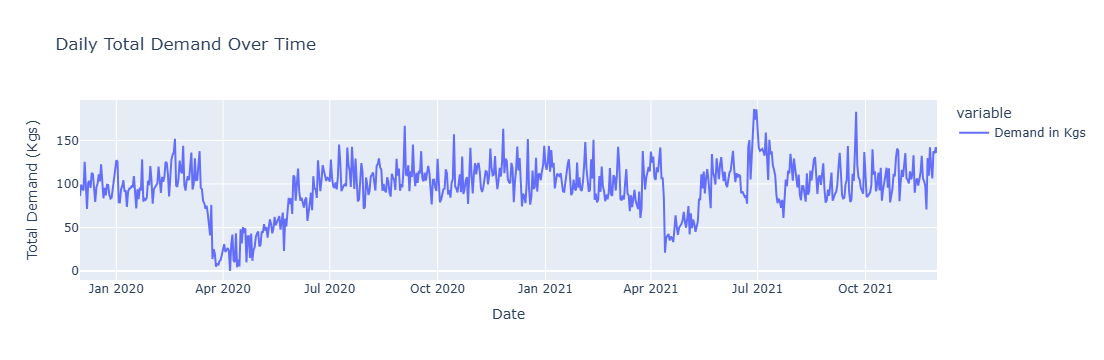

In [25]:
fig_daily = px.line(daily_demand, title='Daily Total Demand Over Time', labels={'value': 'Demand in Kgs', 'timestamp': 'Date'})
fig_daily.update_layout(xaxis_title='Date', yaxis_title='Total Demand (Kgs)')


### X-Gboost

In [171]:
#!pip install xgboost


In [669]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

In [671]:
df_xgb = daily_demand.copy()


In [673]:
df_xgb['dayofweek'] = df_xgb.index.dayofweek
df_xgb['is_weekend'] = df_xgb['dayofweek'].isin([4, 5]).astype(int)
df_xgb['lag_1'] = df_xgb['Demand in Kgs'].shift(1)
df_xgb['lag_2'] = df_xgb['Demand in Kgs'].shift(2)
df_xgb['rolling_mean_3'] = df_xgb['Demand in Kgs'].shift(1).rolling(window=3).mean()

In [675]:
df_xgb.dropna(inplace=True)


In [677]:
X = df_xgb.drop('Demand in Kgs', axis=1)
y = df_xgb['Demand in Kgs']

In [679]:
X_train, X_test = X[:-7], X[-7:]
y_train, y_test = y[:-7], y[-7:]

In [681]:
model = XGBRegressor(n_estimators=10000, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

In [683]:
y_pred = model.predict(X_test)


In [685]:
def evaluate_model(true, predicted):
    true = pd.Series(true).reset_index(drop=True)
    predicted = pd.Series(predicted).reset_index(drop=True)
    mae = mean_absolute_error(true, predicted)
    rmse = mean_squared_error(true, predicted, squared=False)
    mape = (abs((true - predicted) / true).replace([np.inf, -np.inf], np.nan).dropna()).mean() * 100
    accuracy = 100 - mape
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'Accuracy': accuracy}

In [687]:
xgb_metrics = evaluate_model(y_test, y_pred)
print("🔍 XGBoost Evaluation:", xgb_metrics)

🔍 XGBoost Evaluation: {'MAE': 10.001735060337609, 'RMSE': 14.633972322930205, 'MAPE': 7.785617353744467, 'Accuracy': 92.21438264625553}


In [ ]:
# إعادة التحضير بدون العمود المستهدف ضمن الـ features
X = df_xgb[['dayofweek', 'is_weekend', 'lag_1', 'lag_2', 'rolling_mean_3']]
y = df_xgb['Demand in Kgs']

# تقسيم train/test
X_train, X_test = X[:-7], X[-7:]
y_train, y_test = y[:-7], y[-7:]

# تدريب الموديل من جديد
model = XGBRegressor(n_estimators=10000, learning_rate=0.1)
model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=10000,
             n_jobs=None, num_parallel_tree=None, ...)

In [691]:
# تجهيز البيانات لليوم 2019-12-01
target_date = pd.Timestamp('2021-12-01')

# استخراج نفس الـ features
x_target = df_pred.loc[target_date, ['dayofweek', 'is_weekend', 'lag_1', 'lag_2', 'rolling_mean_3']].values.reshape(1, -1)

# التنبؤ
predicted_value = model.predict(x_target)[0]
print(f"🔮 Demand on {target_date.date()} is predicted to be: {predicted_value:.2f} Kgs")


🔮 Demand on 2021-12-01 is predicted to be: 134.12 Kgs


In [453]:
def forecast_until_target_date(model, df_base, target_date_str):
    df_extended = df_base.copy()
    df_extended.index = pd.to_datetime(df_extended.index)
    
    target_date = pd.Timestamp(target_date_str)
    last_date = df_extended.index[-1]
    current_date = last_date

    while current_date < target_date:
        next_date = current_date + pd.Timedelta(days=1)

        try:
            lag_1 = df_extended.loc[current_date, 'Demand in Kgs']
            lag_2 = df_extended.loc[current_date - pd.Timedelta(days=1), 'Demand in Kgs']
            rolling = df_extended.loc[current_date - pd.Timedelta(days=2):current_date, 'Demand in Kgs'].mean()
        except KeyError:
            print(f"❌ مش كفاية داتا لبناء المتغيرات ليوم {next_date.date()}")
            break

        x_target = np.array([
            next_date.dayofweek,
            int(next_date.dayofweek >= 5),
            lag_1,
            lag_2,
            rolling
        ]).reshape(1, -1)

        pred = model.predict(x_target)[0]

        df_extended.loc[next_date] = {
            'Demand in Kgs': pred,
            'dayofweek': next_date.dayofweek,
            'is_weekend': int(next_date.dayofweek >= 5),
            'lag_1': lag_1,
            'lag_2': lag_2,
            'rolling_mean_3': rolling
        }

        current_date = next_date

    forecasted_value = df_extended.loc[target_date, 'Demand in Kgs']
    print(f"🔮 Demand on {target_date.date()} is predicted to be: {forecasted_value:.2f} Kgs")
    return forecasted_value


In [479]:
forecast_until_target_date(model, df_pred, "2020-11-26")


🔮 Demand on 2020-11-26 is predicted to be: 163.45 Kgs


163.45379

### LSTM hour

In [737]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# نشتغل على نسخة جديدة علشان متلعبش في الأصلية
df_lstm = df.copy()

# استخدم فقط العمود الأساسي
scaler = MinMaxScaler()
df_lstm['scaled_demand'] = scaler.fit_transform(df_lstm[['Demand in Kgs']])

# نحضر البيانات كـ sequences
def create_sequences(data, window_size=24):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # يوم كامل بالساعات
data = df_lstm['scaled_demand'].values
X, y = create_sequences(data, window_size)

# reshape for LSTM: (samples, timesteps, features)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [739]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(window_size, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

model.fit(X, y, epochs=20, verbose=1)


Epoch 1/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0131
Epoch 2/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0072
Epoch 3/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0068
Epoch 4/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0067
Epoch 5/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0066
Epoch 6/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0069
Epoch 7/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0066
Epoch 8/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0066
Epoch 9/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0065
Epoch 10/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0062
Epoch 11/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0066
Epoch 12/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0063
Epoch 13/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0063
Epoch 14/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0061
Epoch 15/20
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lo

In [741]:
# آخر sequence نستخدمها كبداية للتنبؤ
last_seq = data[-window_size:]

predictions = []
input_seq = last_seq.copy()

for _ in range(12):
    x_input = input_seq.reshape((1, window_size, 1))
    pred = model.predict(x_input, verbose=0)[0][0]
    predictions.append(pred)
    input_seq = np.append(input_seq[1:], pred)

# نفك الترميز من MinMax
predictions_inverse = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


In [743]:
for i, val in enumerate(predictions_inverse.flatten(), start=1):
    print(f"⏱️ Hour +{i}: Predicted Demand = {val:.2f} Kgs")


⏱️ Hour +1: Predicted Demand = 5.73 Kgs
⏱️ Hour +2: Predicted Demand = 6.54 Kgs
⏱️ Hour +3: Predicted Demand = 7.37 Kgs
⏱️ Hour +4: Predicted Demand = 7.70 Kgs
⏱️ Hour +5: Predicted Demand = 7.90 Kgs
⏱️ Hour +6: Predicted Demand = 7.58 Kgs
⏱️ Hour +7: Predicted Demand = 7.48 Kgs
⏱️ Hour +8: Predicted Demand = 8.81 Kgs
⏱️ Hour +9: Predicted Demand = 11.44 Kgs
⏱️ Hour +10: Predicted Demand = 13.57 Kgs
⏱️ Hour +11: Predicted Demand = 13.98 Kgs
⏱️ Hour +12: Predicted Demand = 11.85 Kgs


In [3]:
split = int(len(data) * 0.8)  # مثلاً 80% تدريب، 20% اختبار
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model.fit(X_train, y_train, epochs=300, verbose=1)

# توقع القيم
y_pred = model.predict(X_test)

# فك الترميز
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))


NameError: name 'data' is not defined

In [751]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
mape = np.mean(np.abs((y_test_inv - y_pred_inv) / y_test_inv)) * 100

print(f"📊 MAE: {mae:.2f}")
print(f"📊 RMSE: {rmse:.2f}")
print(f"📊 MAPE: {mape:.2f}%")


📊 MAE: 2.12
📊 RMSE: 2.85
📊 MAPE: 38.03%


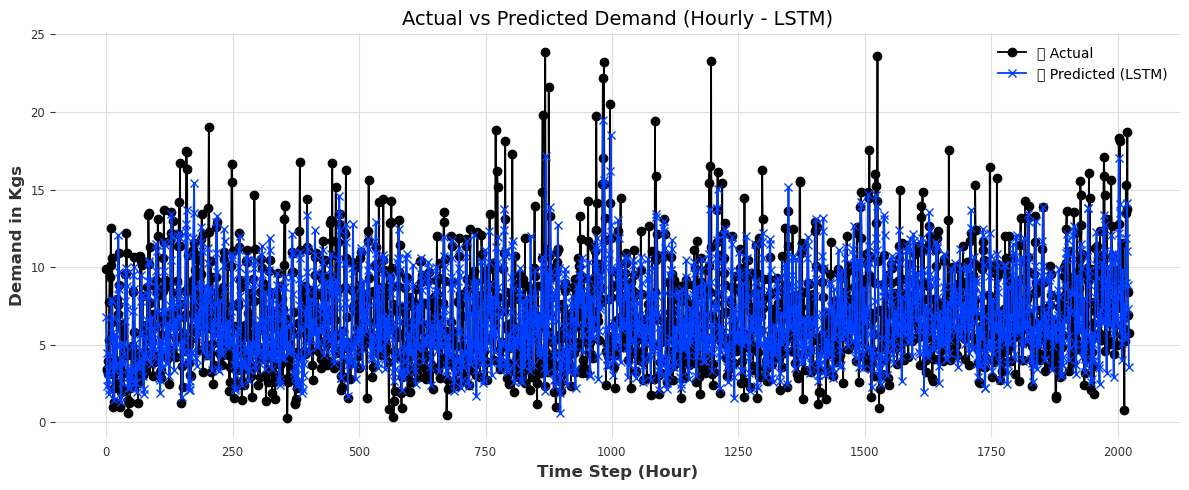

In [753]:
import matplotlib.pyplot as plt

# تأكد إنك بالفعل رجعت القيم من الـ Scaler
# y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
# y_pred_inv = scaler.inverse_transform(y_pred)

plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='🔵 Actual', marker='o')
plt.plot(y_pred_inv, label='🔴 Predicted (LSTM)', marker='x')

plt.title('Actual vs Predicted Demand (Hourly - LSTM)', fontsize=14)
plt.xlabel('Time Step (Hour)', fontsize=12)
plt.ylabel('Demand in Kgs', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### EDA

In [70]:
df

DOB   DAY_NAME  Hour  Demand in Kgs
0      2019-12-01     Sunday     9        3.46070
1      2019-12-01     Sunday    10        5.76400
2      2019-12-01     Sunday    11        5.01463
3      2019-12-01     Sunday    12        6.52433
4      2019-12-01     Sunday    13        7.89140
...           ...        ...   ...            ...
10226  2021-12-01  Wednesday    19       13.76500
10227  2021-12-01  Wednesday    20       18.72590
10228  2021-12-01  Wednesday    21        8.37200
10229  2021-12-01  Wednesday    22        6.94920
10230  2021-12-01  Wednesday    23        5.74450

[10231 rows x 4 columns]

In [72]:
# تأكد إن عمود DOB من نوع datetime
df['DOB'] = pd.to_datetime(df['DOB'])

# 1. السنة
df['Year'] = df['DOB'].dt.year

# 2. الربع السنوي
df['Quarter'] = df['DOB'].dt.quarter

# 3. تحديد AM / PM
df['AM_PM'] = df['Hour'].apply(lambda x: 'AM' if x < 12 else 'PM')

# 4. تحويل لـ نظام 12 ساعة (بسيب الساعة 12 زي ما هي)
df['Hour_12'] = df['Hour'].apply(lambda x: 12 if x == 12 or x == 0 else x % 12)


In [74]:
df.head()

DOB DAY_NAME  Hour  Demand in Kgs  Year  Quarter AM_PM  Hour_12
0 2019-12-01   Sunday     9        3.46070  2019        4    AM        9
1 2019-12-01   Sunday    10        5.76400  2019        4    AM       10
2 2019-12-01   Sunday    11        5.01463  2019        4    AM       11
3 2019-12-01   Sunday    12        6.52433  2019        4    PM       12
4 2019-12-01   Sunday    13        7.89140  2019        4    PM        1

In [76]:
df['Year'].value_counts()

Year
2020    4917
2021    4868
2019     446
Name: count, dtype: int64

In [78]:
    df['weekday'] = df['DOB'].dt.day_name()

# نحسب عدد كل يوم في كل سنة
weekday_distribution = df.groupby(['Year', 'weekday']).size().unstack().fillna(0)

# نعرض النتيجة
print(weekday_distribution)


weekday  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
Year                                                                   
2019         60      72        57      70        58       72         57
2020        688     699       693     702       727      686        722
2021        700     700       700     700       684      688        696


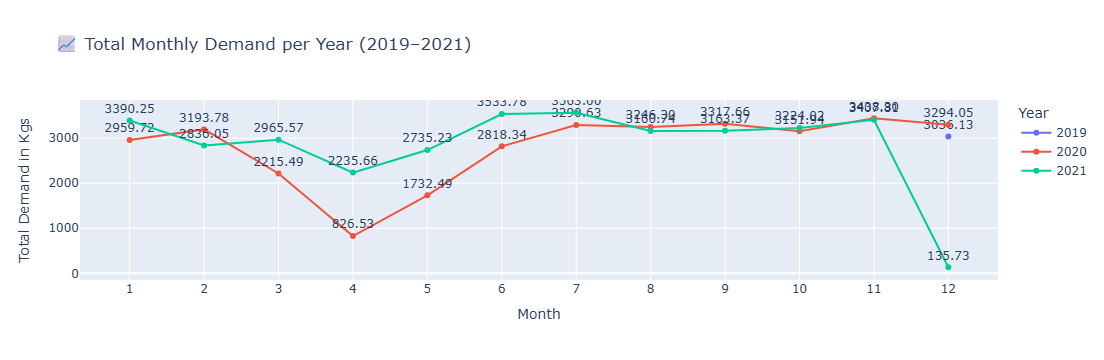

In [80]:
import plotly.express as px

# تأكد إن التاريخ بصيغة datetime
df['DOB'] = pd.to_datetime(df['DOB'])

# استخراج السنة والشهر
df['Year'] = df['DOB'].dt.year
df['Month'] = df['DOB'].dt.month

# فلترة السنوات المطلوبة
df_filtered = df[df['Year'].isin([2019, 2020, 2021])]

# حساب إجمالي الطلب الشهري
monthly_sum = df_filtered.groupby(['Year', 'Month'])['Demand in Kgs'].sum().reset_index()

# رسم الخط مع markers + data labels
fig = px.line(monthly_sum,
              x='Month',
              y='Demand in Kgs',
              color='Year',
              markers=True,
              text='Demand in Kgs',  # لإظهار الأرقام

              title='📈 Total Monthly Demand per Year (2019–2021)',
              labels={'Month': 'Month', 'Demand in Kgs': 'Total Demand in Kgs', 'Year': 'Year'})

# تنسيق العرض
fig.update_traces(textposition="top center", texttemplate='%{text:.2f}')
fig.update_layout(xaxis=dict(dtick=1), showlegend=True)

fig.show()



In [82]:
# تأكد إن التاريخ بصيغة datetime
df['DOB'] = pd.to_datetime(df['DOB'])

# استخراج السنة والربع
df['Year'] = df['DOB'].dt.year
df['Quarter'] = df['DOB'].dt.quarter

# إنشاء عمود جديد بالشكل "Q1 2020"
df['Quarter_Year'] = 'Q' + df['Quarter'].astype(str) + ' ' + df['Year'].astype(str)


In [84]:
# حساب الإجمالي حسب الربع
quarterly_sum = df.groupby('Quarter_Year')['Demand in Kgs'].sum().reset_index()

# لو عايز ترتبهم ترتيب زمني:
quarterly_sum['Quarter_Year'] = pd.Categorical(
    quarterly_sum['Quarter_Year'],
    categories=sorted(df['Quarter_Year'].unique(), key=lambda x: (int(x.split()[1]), int(x[1]))),
    ordered=True
)

quarterly_sum = quarterly_sum.sort_values('Quarter_Year')


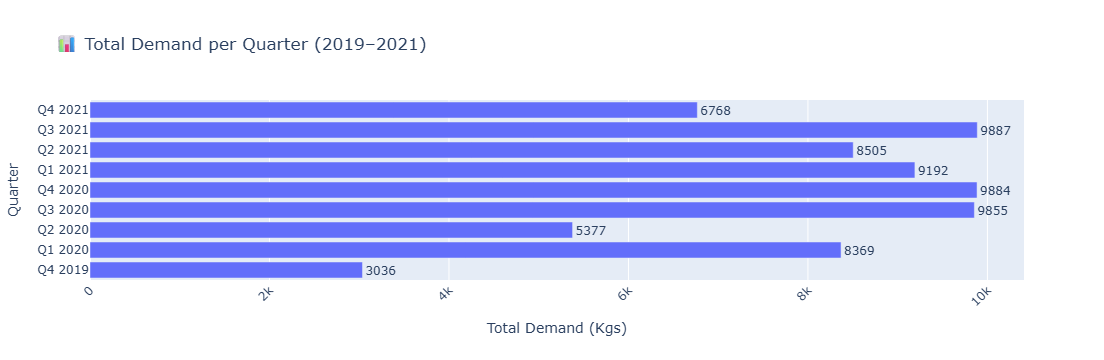

In [94]:
import plotly.express as px

fig = px.bar(quarterly_sum,
             x='Demand in Kgs',
             y='Quarter_Year',
             text='Demand in Kgs',
             title='📊 Total Demand per Quarter (2019–2021)',
             labels={'Quarter_Year': 'Quarter', 'Demand in Kgs': 'Total Demand (Kgs)'})

fig.update_traces(texttemplate='%{text:.0f}', textposition='outside')
fig.update_layout(xaxis_tickangle=-45)

fig.show()


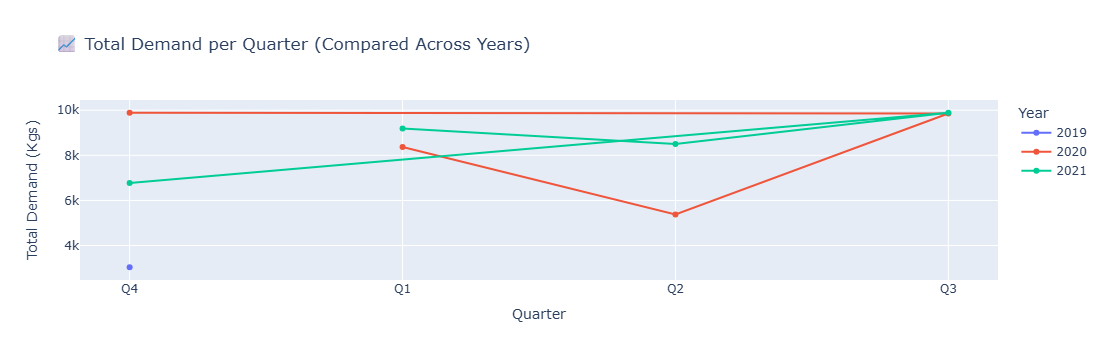

In [98]:
import plotly.express as px
# حساب إجمالي الطلب لكل Quarter وسنة
quarterly = df.groupby(['Year', 'Quarter'])['Demand in Kgs'].sum().reset_index()

# تحويل الربع لاسم مثل Q1, Q2...
quarterly['Quarter_Label'] = 'Q' + quarterly['Quarter'].astype(str)

# رسم Line Chart
fig = px.line(quarterly,
              x='Quarter_Label',
              y='Demand in Kgs',
              color='Year',
              markers=True,
              title='📈 Total Demand per Quarter (Compared Across Years)',
              labels={'Quarter_Label': 'Quarter', 'Demand in Kgs': 'Total Demand (Kgs)', 'Year': 'Year'})

# إظهار الأرقام فوق النقاط
fig.update_traces(text=quarterly['Demand in Kgs'].round(0),
                  textposition='top center')

fig.show()


In [124]:
df

DOB   DAY_NAME  Hour  Demand in Kgs  Year  Quarter AM_PM  \
0     2019-12-01     Sunday     9        3.46070  2019        4    AM   
1     2019-12-01     Sunday    10        5.76400  2019        4    AM   
2     2019-12-01     Sunday    11        5.01463  2019        4    AM   
3     2019-12-01     Sunday    12        6.52433  2019        4    PM   
4     2019-12-01     Sunday    13        7.89140  2019        4    PM   
...          ...        ...   ...            ...   ...      ...   ...   
10226 2021-12-01  Wednesday    19       13.76500  2021        4    PM   
10227 2021-12-01  Wednesday    20       18.72590  2021        4    PM   
10228 2021-12-01  Wednesday    21        8.37200  2021        4    PM   
10229 2021-12-01  Wednesday    22        6.94920  2021        4    PM   
10230 2021-12-01  Wednesday    23        5.74450  2021        4    PM   

       Hour_12    weekday  Month Quarter_Year  
0            9     Sunday     12      Q4 2019  
1           10     Sunday     12      Q4 2019  
2           11     Sunday     12      Q4 2019  
3           12     Sunday     12      Q4 2019  
4            1     Sunday     12      Q4 2019  
...        ...        ...    ...          ...  
10226        7  Wednesday     12      Q4 2021  
10227        8  Wednesday     12      Q4 2021  
10228        9  Wednesday     12      Q4 2021  
10229       10  Wednesday     12      Q4 2021  
10230       11  Wednesday     12      Q4 2021  

[10231 rows x 11 columns]

In [126]:
df['Hour_AMPM'] = df['Hour_12'].astype(str) + ' ' + df['AM_PM']


In [128]:
hourly_summary = df.groupby(['Year', 'Month', 'Hour_AMPM'])['Demand in Kgs'].sum().reset_index()


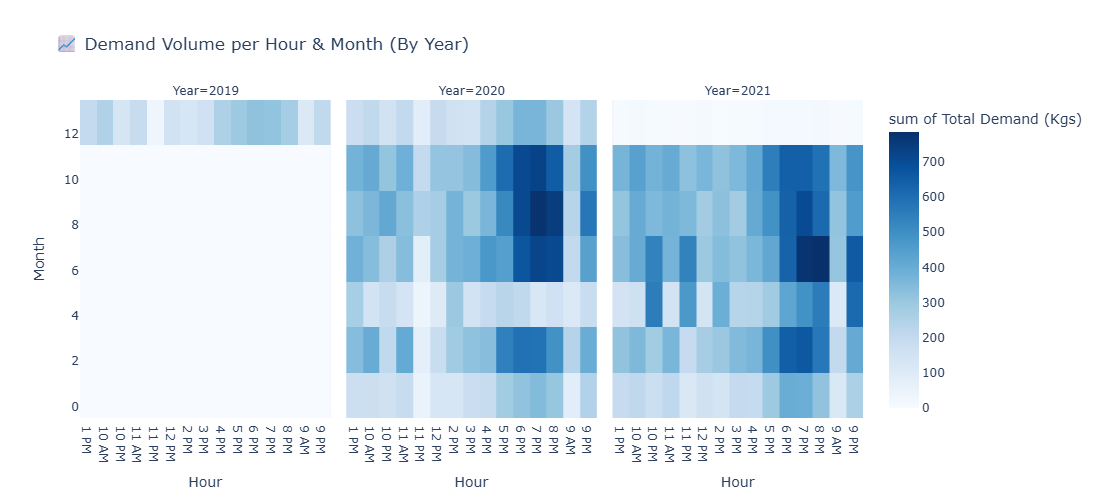

In [130]:
import plotly.express as px

fig = px.density_heatmap(hourly_summary,
                         x='Hour_AMPM',
                         y='Month',
                         z='Demand in Kgs',
                         facet_col='Year',
                         color_continuous_scale='Blues',
                         title='📈 Demand Volume per Hour & Month (By Year)',
                         labels={'Demand in Kgs': 'Total Demand (Kgs)', 'Hour_AMPM': 'Hour'})

fig.update_layout(height=500, width=1000)
fig.show()
